In [ ]:
# Install required packages.
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
!pip install -q torch-geometric
!pip install pycox

     |████████████████████████████████| 3.0 MB 5.9 MB/s 
     |████████████████████████████████| 1.6 MB 3.5 MB/s 
     |████████████████████████████████| 222 kB 5.3 MB/s 
     |████████████████████████████████| 376 kB 9.9 MB/s 
     |████████████████████████████████| 45 kB 1.3 MB/s 
     |████████████████████████████████| 73 kB 1.4 MB/s 
     |████████████████████████████████| 41 kB 460 kB/s 
     |████████████████████████████████| 65 kB 2.5 MB/s 
     |████████████████████████████████| 1.9 MB 9.1 MB/s 
     |████████████████████████████████| 2.2 MB 31.4 MB/s 
     |████████████████████████████████| 121 kB 62.4 MB/s 
     |████████████████████████████████| 357 kB 50.7 MB/s 


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader 
from torchvision import datasets, transforms
import torchtuples as tt
from pycox.models import LogisticHazard
from pycox.utils import kaplan_meier
from pycox.evaluation import EvalSurv
from torch_geometric.datasets import TUDataset,MNISTSuperpixels
import pandas as pd
import torch
import torch_geometric
from torch_geometric.data import Dataset, Data
import numpy as np 
import os
from tqdm import tqdm
import pandas as pd
from scipy.spatial.distance import squareform
from scipy.spatial.distance import pdist
import time
from scipy.sparse import csr_matrix
import torch 


In [ ]:
# for reproducability
np.random.seed(1234)
_ = torch.manual_seed(1234)

import graph datasets

In [ ]:
mnist_train = MNISTSuperpixels(root='data/MNISTSuperpixels', train=True)
mnist_test = MNISTSuperpixels(root='data/MNISTSuperpixels', train=False)

Extracting data/MNISTSuperpixels/raw/mnist_superpixels.tar.gz
Processing...
Done!


add time to event data

In [ ]:
def sim_event_times(mnist, max_time=700):
    digits = []
    for i in range(len(mnist)):
      digits.append(mnist.get(i).y.numpy()[0])
    digits = np.asarray(digits)
    betas = 365 * np.exp(-0.6 * digits) / np.log(1.2)
    event_times = np.random.exponential(betas)
    censored = event_times > max_time
    event_times[censored] = max_time
    return tt.tuplefy(event_times, ~censored)

In [ ]:
sim_train = sim_event_times(mnist_train)
sim_test = sim_event_times(mnist_test)

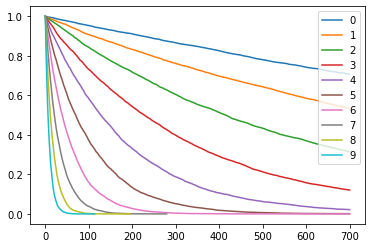

In [ ]:
digits = []
for i in range(len(mnist_train)):
  digits.append(mnist_train.get(i).y.numpy()[0])
digits = np.asarray(digits)

for i in range(10):
    
    idx = digits == i
    kaplan_meier(*sim_train.iloc[idx]).rename(i).plot()
_ = plt.legend()

In [ ]:
labtrans = LogisticHazard.label_transform(20)
target_train = labtrans.fit_transform(*sim_train)
target_test = labtrans.transform(*sim_test)

In [ ]:

class MnistSimDatasetSingle(Dataset):
    """Simulatied data from MNIST. Read a single entry at a time.
    """
    def __init__(self, mnist_dataset, time, event, root, test = False, transform=None, pre_transform=None):
        self.mnist_dataset = mnist_dataset
        self.time, self.event = tt.tuplefy(time, event).to_tensor()
        self.test = test
        self.root = root
        #self.num_node_features = mnist_dataset.num_node_features

    def __len__(self):
        return len(self.mnist_dataset)

    def __getitem__(self, index):
        
        """ - Equivalent to __getitem__ in pytorch
            - Is not needed for PyG's InMemoryDataset
        """
        if self.test:
            data = torch.load(os.path.join(self.processed_dir, 
                                 f'test.pt'))
        else:
            data = torch.load(os.path.join(self.processed_dir, 
                                 f'training.pt'))   
        return data
        

In [ ]:
dataset_train = MnistSimDatasetSingle(mnist_train, *target_train,root='data/MNISTSuperpixels', test=False)
dataset_test = MnistSimDatasetSingle(mnist_test, *target_test,root='data/MNISTSuperpixels', test=True)

Define data loaders

In [ ]:
def collate_fn(batch):
    """Stacks the entries of a nested tuple"""
    return tt.tuplefy(batch).stack()

In [ ]:
batch_size = 128

In [ ]:
dl_train = DataLoader(dataset_train, batch_size, shuffle=True, collate_fn=collate_fn)
dl_test = DataLoader(dataset_test, batch_size, shuffle=False, collate_fn=collate_fn)

Define graph neural network

In [ ]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(mnist_train.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels,labtrans.out_features)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x


training



In [ ]:
net = GCN(hidden_channels=10)
print(net)
model = LogisticHazard(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts)

GCN(
  (conv1): GCNConv(1, 10)
  (conv2): GCNConv(10, 10)
  (conv3): GCNConv(10, 10)
  (lin): Linear(in_features=10, out_features=20, bias=True)
)


In [ ]:
callbacks = [tt.cb.EarlyStopping(patience=5)]
epochs = 10
verbose = True
log = model.fit_dataloader(dl_train, epochs, callbacks, verbose, val_dataloader=dl_test)